[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building CMNDs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.9.3. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

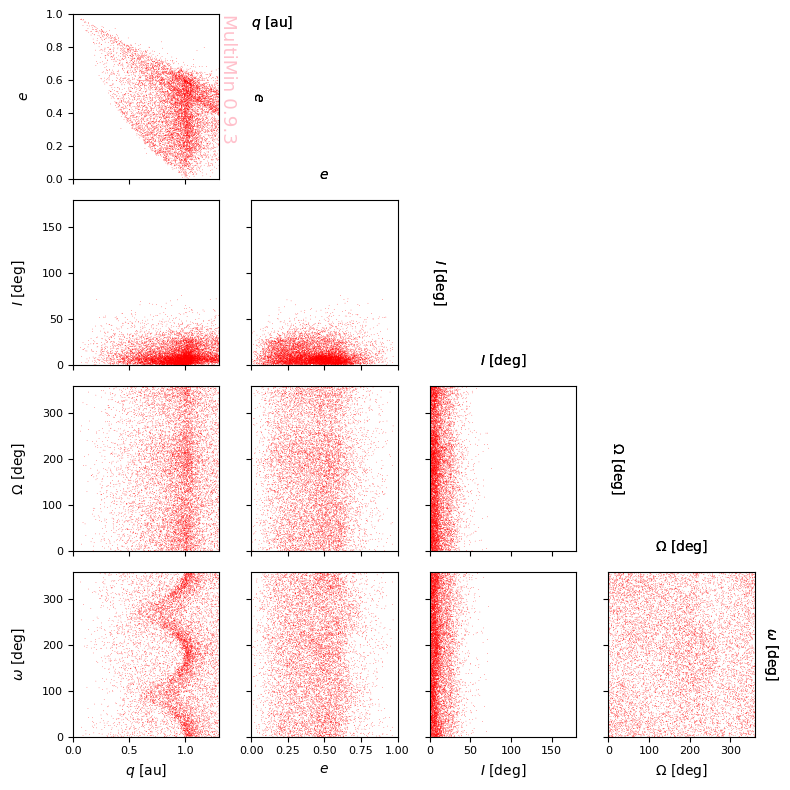

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.DensityPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

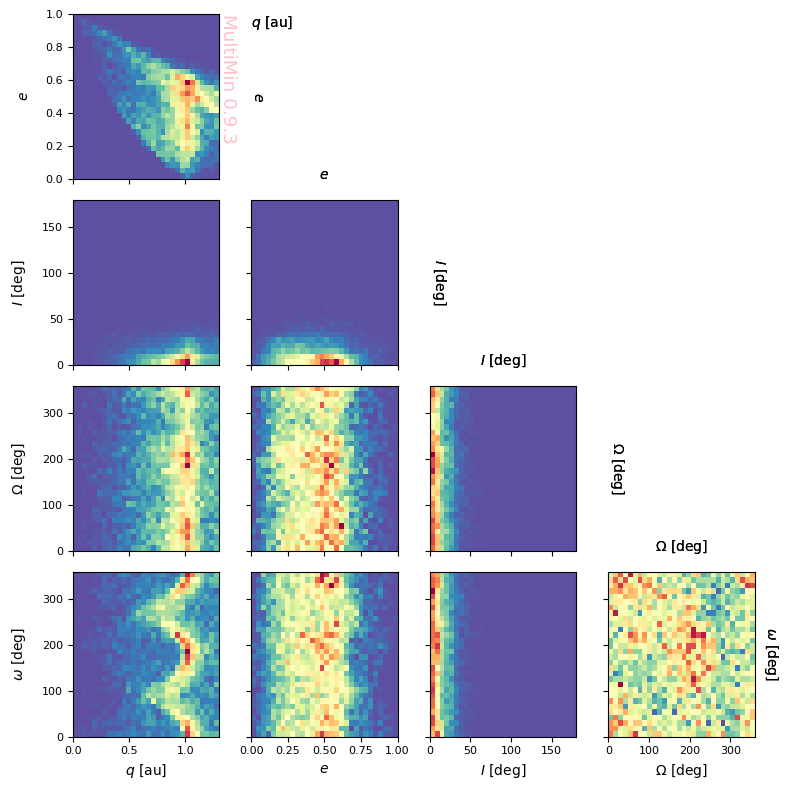

In [5]:
G=mn.DensityPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [6]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

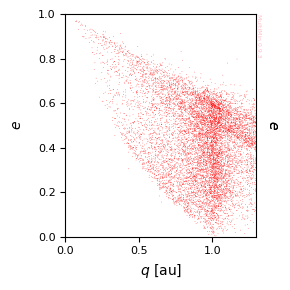

In [7]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [8]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(data_neas_qe, advance=0)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Elapsed time since last call: 107.216 ms
-log(L)/N = -0.5247983016125343


And check the fit result:

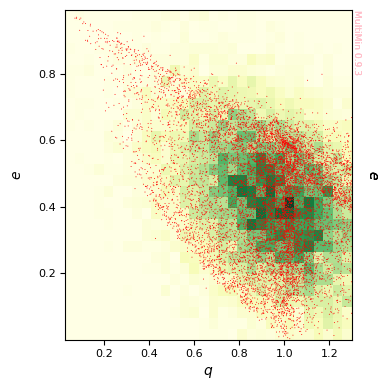

In [9]:
props=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qe_1.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [10]:
F_qe_1.cmnd.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.967596,0.413301,0.26992,0.19018,-0.434965


We can do it better increasing the number of normals:

In [11]:
t = mn.Util.el_time(0)
F = mn.FitCMND(ngauss=5, nvars=2, domain=[[0,1.3], [0, 1]])
F.fit_data(data_neas_qe)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Elapsed time since last call: 19.9053 s
-log(L)/N = -0.7138536292746296


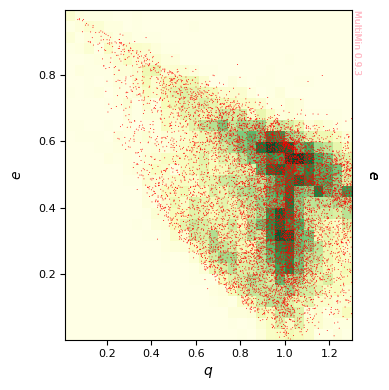

In [12]:
props=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [13]:
neas_sample = F.cmnd.rvs(len(data_neas_qe))

And plot it:

Text(0.5, 1.0, 'Original data')

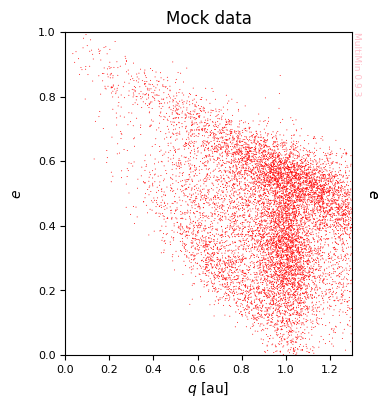

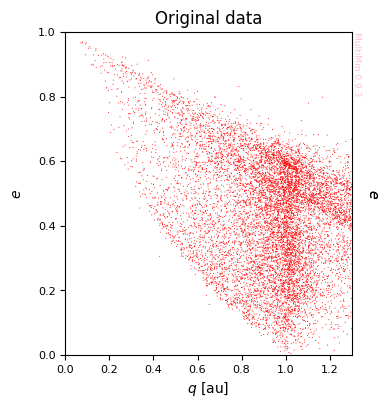

In [14]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.DensityPlot(properties,figsize=4)
G.scatter_plot(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.DensityPlot(properties,figsize=4)
scatter=G.scatter_plot(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [15]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.cmnd.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
2,0.305690,0.922601,0.393220,0.278549,0.161718,-0.725174
3,0.231290,0.999054,0.311922,0.068685,0.146216,-0.146673
4,0.225555,1.193944,0.472691,0.478832,0.202857,-0.971995
5,0.127048,1.051719,0.559343,0.159832,0.057231,-0.354738
1,0.110417,0.732006,0.249190,0.166977,0.117684,-0.887412


In [16]:
function, cmnd = F.cmnd.get_function(properties=properties)

import numpy as np
from multimin import tnmd

def cmnd(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.732006
    mu1_e = 0.24919
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.027881, -0.017438], [-0.017438, 0.013849]]
    Z1 = 0.98288
    n1 = tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.922601
    mu2_e = 0.39322
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.077589, -0.032667], [-0.032667, 0.026153]]
    Z2 = 0.910352
    n2 = tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 0.999054
    mu3_e = 0.311922
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.004718, -0.001473], [-0.001473, 0.021379]]
    Z3 = 0.983543
    n3 = tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.193944
    mu4_e = 0.472691
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.229281, -0.094414], [-0.094414, 0.041151]]
    Z4 = 0.580542
    n4 = tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.051719
    mu5_e = 0.559343
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.025546, -0.003245], [-0.003245, 0.003275]]
    Z5 = 0.939835
    n5 

### Fitting other pair of properties

Fitting $q$ and $I$:

-log(L)/N = 3.472556522741656


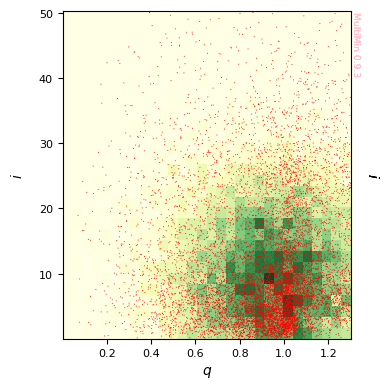

In [17]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(data_neas_qi, advance=0)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

props=["q","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qi_1.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

-log(L)/N = 3.2917400711816605


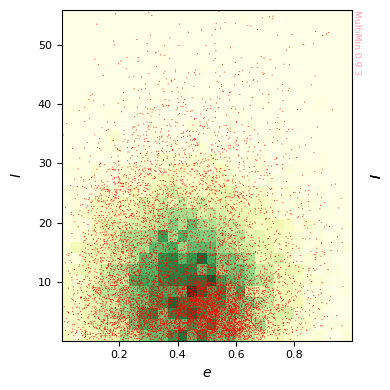

In [18]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(data_neas_ei, advance=0)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

props=["e","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [19]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

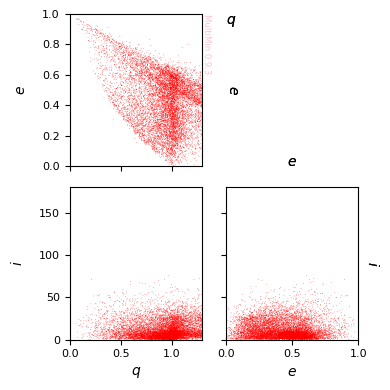

In [20]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.DensityPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.scatter_plot(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Iterations:
Iter 0:
	Vars: [0.38, 0.5, 0.0028, -2.5, -2.2, -7.5, 1, 1.1, 0.72]
	LogL/N: 689.7941319493815
Iter 1:
	Vars: [0.38, 0.5, 0.051, -2.5, -2.2, -7.5, 1, 1.1, 0.67]
	LogL/N: 689.4120694177266
Iter 2:
	Vars: [0.38, 0.5, 0.07, -2.5, -2.2, -7.5, 1, 1.1, 0.75]
	LogL/N: 689.2258974106355
Iter 3:
	Vars: [0.37, 0.49, 0.065, -2.5, -2.2, -7.5, 1, 1, 0.75]
	LogL/N: 689.2712035545522
Iter 4:
	Vars: [0.37, 0.49, 0.058, -2.5, -2.2, -7.5, 1, 1, 0.76]
	LogL/N: 689.3453466368632
Iter 5:
	Vars: [0.37, 0.49, 0.059, -2.5, -2.2, -7.5, 1, 1, 0.75]
	LogL/N: 689.3311144002506
Iter 6:
	Vars: [0.37, 0.49, 0.063, -2.5, -2.2, -7.5, 1, 1, 0.75]
	LogL/N: 689.2950677980533
Iter 7:
	Vars: [0.37, 0.49, 0.063, -2.5, -2.2, -7.5, 1, 1, 0.75]
	LogL/N: 689.2950661649168
Iter 8:
	Vars: [0.37, 0.49, 0.063, -2.5, -2.2, -7.5, 1, 1, 0.75]
	LogL/N: 689.2950661618976
-log(L)/N = 61.45845987932712


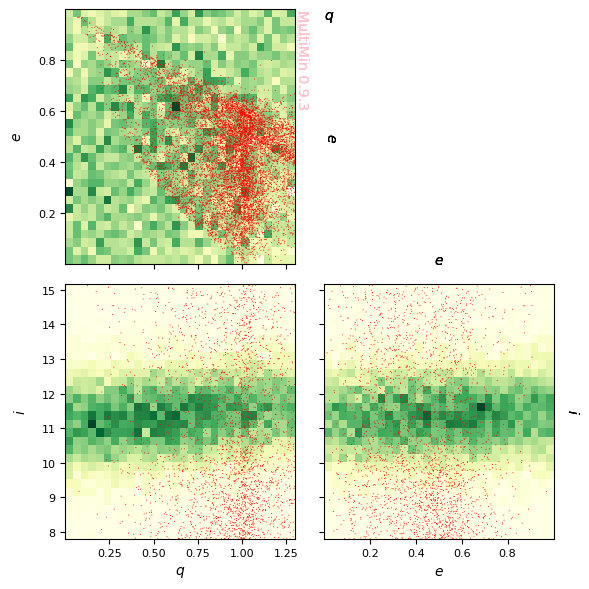

In [21]:
fit_qei = mn.FitCMND(ngauss=1, nvars=3, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(data_neas_qei, advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

props=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

Iterations:
Iter 0:
	Vars: [0.74, 0.42, 0.046, -3.9, -4, -5.2, -0.93, -0.014, -0.11]
	LogL/N: 674.192099247131
Iter 1:
	Vars: [0.74, 0.42, 0.046, -3.9, -4, -5.2, -0.93, -0.014, -0.11]
	LogL/N: 674.1920994015628
Iter 2:
	Vars: [0.74, 0.42, 0.046, -3.9, -4, -5.2, -0.93, -0.014, -0.11]
	LogL/N: 674.1920994128508
Iter 3:
	Vars: [0.74, 0.42, 0.046, -3.9, -4, -5.2, -0.93, -0.014, -0.11]
	LogL/N: 674.1920994820634
-log(L)/N = -2.371662497614012


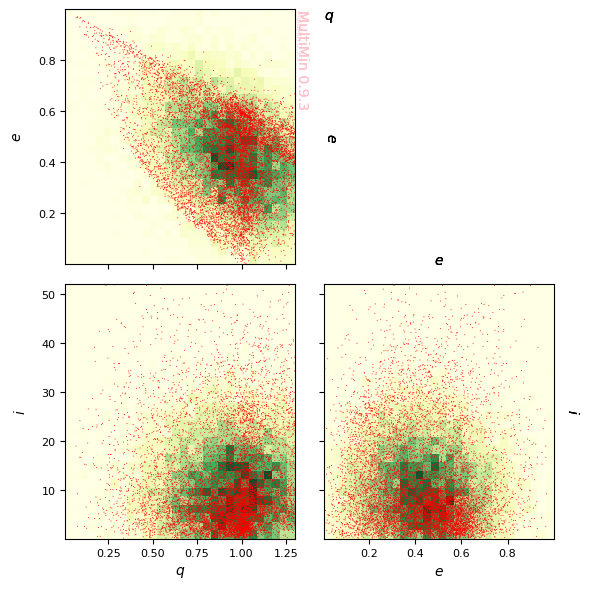

In [22]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.cmnd.mus[0, 0] + F_qi_1.cmnd.mus[0, 0]) / 2
mu_e = (F_qe_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 0]) / 2
mu_i = (F_qi_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 1]) / 2
sigma_q = (F_qe_1.cmnd.sigmas[0, 0] + F_qi_1.cmnd.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.cmnd.rhos[0, 0])
rho_qi = float(F_qi_1.cmnd.rhos[0, 0])
rho_ei = float(F_ei_1.cmnd.rhos[0, 0])

fit_qei = mn.FitCMND(ngauss=1, nvars=3, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(data_neas_qei, advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

props=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Iterations:
Iter 0:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.97, 0.42, 8.4, 0.97, 0.42, 8.4, 0.97, 0.42, 8.4, 0.97, 0.42, 8.4, 0.97, 0.42, 8.4, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.93, -0.014, -0.11, -0.93, -0.014, -0.11, -0.93, -0.014, -0.11, -0.93, -0.014, -0.11, -0.93, -0.014, -0.11]
	LogL/N: 3.083660076176727


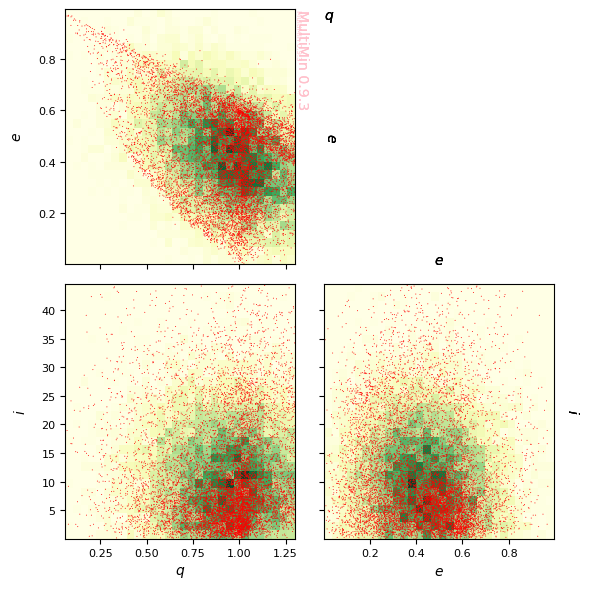

In [23]:
fit_qei = mn.FitCMND(ngauss=5, nvars=3, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(data_neas_qei, advance=True)
G=fit_qei.plot_fit(
    props=props,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the CMND is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the CMND in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [24]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **DensityPlot** (scatter on pairwise panels):

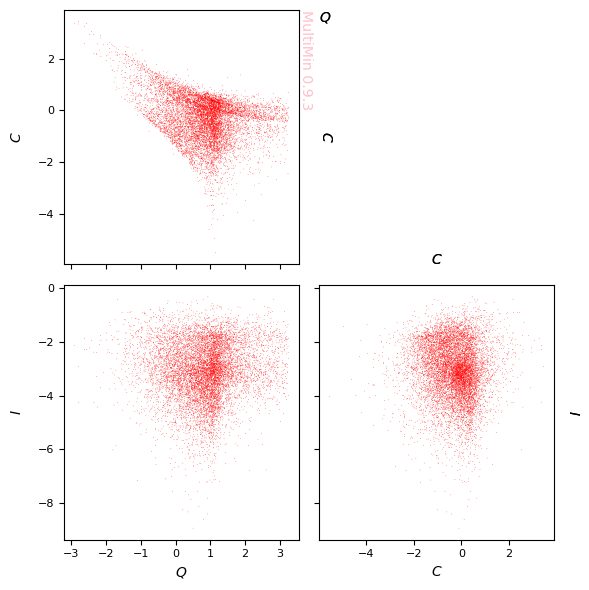

In [25]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.DensityPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

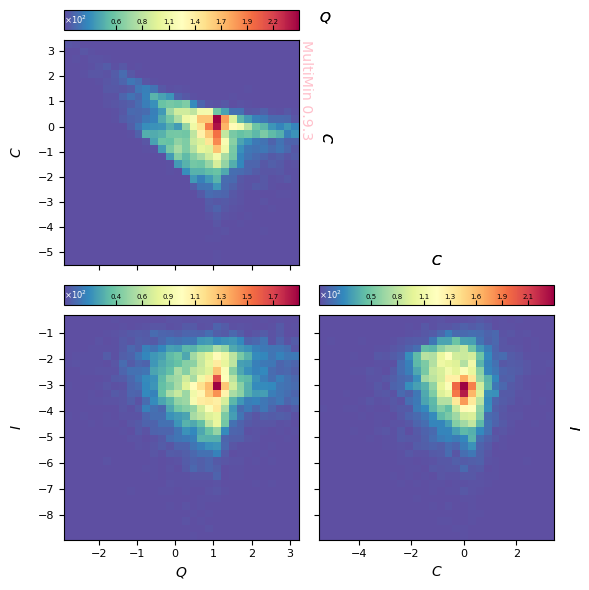

In [26]:
G=mn.DensityPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [27]:
F=mn.FitCMND(ngauss=1,nvars=3)

The fitter holds an initial CMND that will be optimized:

In [28]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.0, 0.0, 0.0]]
    Standard deviations (σ): [[1.0, 1.0, 1.0]]
    Correlation coefficients (ρ): [[0.0, 0.0, 0.0]]

    Covariant matrices (Σ): 
        [[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


Run the minimization:

In [29]:
t = mn.Util.el_time(0)
F.fit_data(udata,verbose=False,advance=1)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Iterations:
Iter 0:
	Vars: [2.3, 1.4, -2, -1.9, -1.6, -1.8, 1.4, 1.1, 1.1]
	LogL/N: 5.286390111152584
Iter 1:
	Vars: [1.7, 0.52, -2.5, -1.8, -1.8, -1.9, 1.1, 1, 0.81]
	LogL/N: 4.7427558325781805
Iter 2:
	Vars: [0.8, -0.38, -3.1, -2.1, -2.2, -2, -0.068, 0.25, 0.5]
	LogL/N: 4.116602662121965
Iter 3:
	Vars: [0.85, -0.35, -3.1, -2.4, -2.3, -2.1, -0.65, 0.077, -0.089]
	LogL/N: 3.9771714140887715
Iter 4:
	Vars: [0.85, -0.34, -3.1, -2.4, -2.4, -2.1, -0.67, 0.088, -0.13]
	LogL/N: 3.976208897437413
Iter 5:
	Vars: [0.84, -0.33, -3.1, -2.4, -2.4, -2.1, -0.67, 0.088, -0.14]
	LogL/N: 3.9759796388117206
Iter 6:
	Vars: [0.84, -0.33, -3.1, -2.4, -2.4, -2.1, -0.67, 0.088, -0.14]
	LogL/N: 3.9759796388117206
Elapsed time since last call: 147.074 ms
-log(L)/N = 3.9759796388117206


Inspect the fitted CMND:

In [30]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8432043732684243, -0.32847034967936206, -3.0673740269872054]]
    Standard deviations (σ): [[0.8608846345876456, 0.8693022748783629, 1.0701272289997632]]
    Correlation coefficients (ρ): [[-0.3230989388852171, 0.04384139956243471, -0.0685521459926749]]

    Covariant matrices (Σ): 
        [[[0.7411223540691042, -0.24179722050706956, 0.040389156275243296], [-0.24179722050706956, 0.7556864451086968, -0.06377159591017881], [0.040389156275243296, -0.06377159591017881, 1.1451722862467115]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8432043732684243, -0.32847034967936206, -3.0673740269872054, 0.7411223540691042, -0.24179722050706956, 0.040389156275243296, 0.7556864451086968, -0.06377159591017881, 1.1451722862467115]
        With std. and 

Plot the fit result (fitted sample + data scatter):

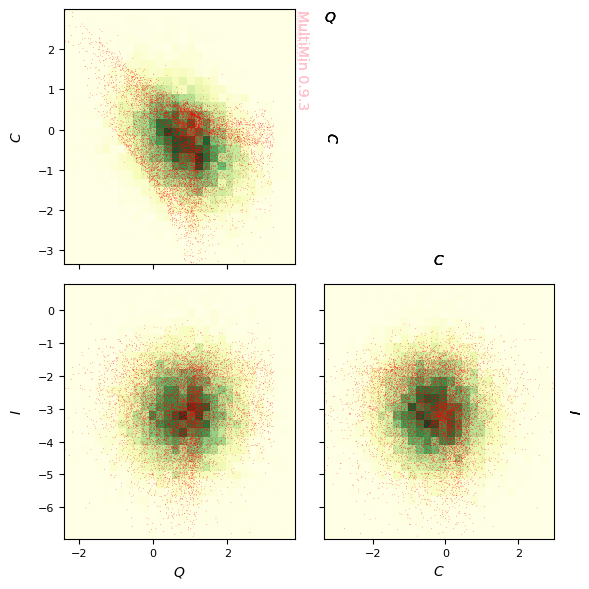

In [31]:
props=["Q","C","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
G=F.plot_fit(props=props,hargs=hargs,sargs=sargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [32]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [33]:
F=mn.FitCMND(f"gallery/{figprefix}_fit-single.pkl")
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8432043732684243, -0.32847034967936206, -3.0673740269872054]]
    Standard deviations (σ): [[0.8608846345876456, 0.8693022748783629, 1.0701272289997632]]
    Correlation coefficients (ρ): [[-0.3230989388852171, 0.04384139956243471, -0.0685521459926749]]

    Covariant matrices (Σ): 
        [[[0.7411223540691042, -0.24179722050706956, 0.040389156275243296], [-0.24179722050706956, 0.7556864451086968, -0.06377159591017881], [0.040389156275243296, -0.06377159591017881, 1.1451722862467115]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8432043732684243, -0.32847034967936206, -3.0673740269872054, 0.7411223540691042, -0.24179722050706956, 0.040389156275243296, 0.7556864451086968, -0.06377159591017881, 1.1451722862467115]
        With std. and 

Fit with two Gaussian components for a better likelihood:

Iterations:
Iter 0:
	Vars: [0, 0, 2.7, 1.4, -2.1, 1.8, 0.51, -2.3, -1.2, -1.4, -1.6, -2.1, -2.1, -2, 1.4, 1.2, 1.1, 1.3, 1.3, 0.87]
	LogL/N: 4.966056615224744


Iter 5:
	Vars: [-1.3, 0.0074, 0.22, 0.33, -3.3, 1.1, -0.58, -3, -2.4, -2.6, -1.9, -2.5, -2.5, -2.2, -1.5, -0.65, 0.34, 0.1, 0.28, -0.13]
	LogL/N: 3.896621507884651


Iter 10:
	Vars: [-1.5, 0.0065, 0.4, 0.49, -3.5, 0.98, -0.6, -2.9, -2.3, -2.8, -2, -2.4, -2.5, -2.2, -2.4, -0.71, 0.7, -0.073, 0.21, 0.016]
	LogL/N: 3.8852544818076042
Iter 11:
	Vars: [-1.5, 0.0065, 0.4, 0.49, -3.5, 0.98, -0.6, -2.9, -2.3, -2.8, -2, -2.4, -2.5, -2.2, -2.4, -0.71, 0.7, -0.073, 0.21, 0.016]
	LogL/N: 3.8852544818076042
Elapsed time since last call: 977.83 ms
-log(L)/N = 3.8852544818076042
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.25955254580760684, 0.7404474541923931]
    Number of variables: 3
    Averages (μ): [[0.3986083421627656, 0.49098944038409126, -3.533428129736972], [0.9787413770219017, -0.5953545183512837, -2.9107981675869663]]
    Standard deviations (σ): [[0.8722412079559161, 0.5910423557566333, 1.197598119649095], [0.8104588129277843, 0.7715000826556432, 0.9742052036058405]]
    Correlation coefficients (ρ): [[-0.8298457642093784, -0.33976965152816274, 0.33790831640131747], [-0.03633743810282952, 0.10279885

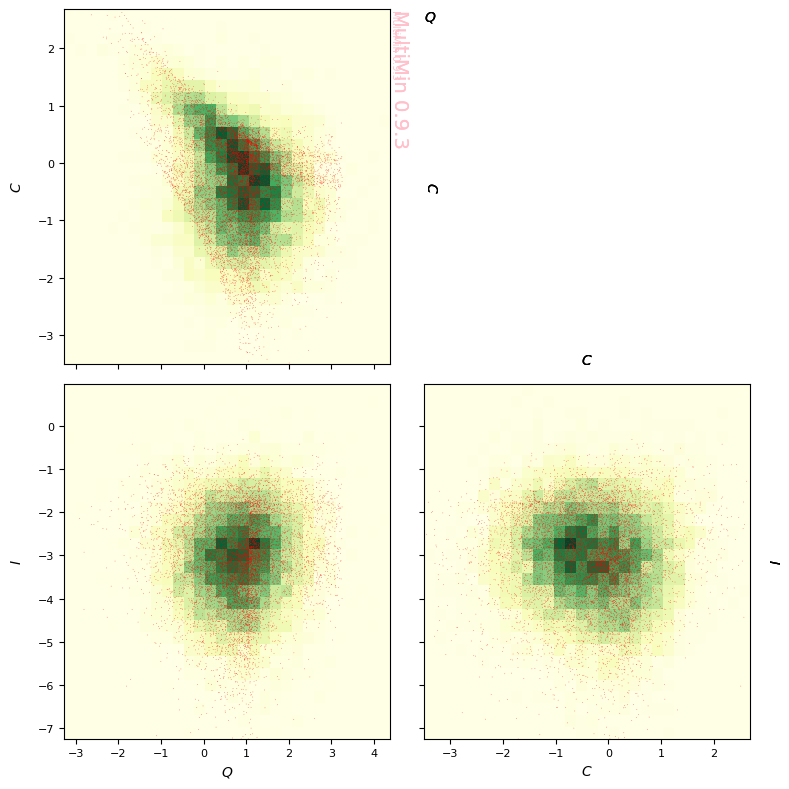

In [34]:
F=mn.FitCMND(ngauss=2,nvars=3)

mn.Util.el_time(0)
F.fit_data(udata,advance=5)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)

G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.7, 1.4, -2.1, 1.8, 0.51, -2.3, -1.2, -1.4, -1.6, -2.1, -2.1, -2, 1.4, 1.2, 1.1, 1.3, 1.3, 0.87]
	LogL/N: 4.964225747993637


Iter 5:
	Vars: [-0.55, 2.2, 0.21, 0.33, -3.3, 1.1, -0.58, -3, -2.4, -2.6, -1.9, -2.5, -2.5, -2.2, -1.5, -0.65, 0.34, 0.1, 0.28, -0.13]
	LogL/N: 3.896589673616044


Iter 10:
	Vars: [-0.78, 2.2, 0.4, 0.49, -3.5, 0.98, -0.59, -2.9, -2.3, -2.8, -2, -2.4, -2.5, -2.2, -2.4, -0.71, 0.7, -0.073, 0.21, 0.015]
	LogL/N: 3.88525610364571
Iter 11:
	Vars: [-0.78, 2.2, 0.4, 0.49, -3.5, 0.98, -0.59, -2.9, -2.3, -2.8, -2, -2.4, -2.5, -2.2, -2.4, -0.71, 0.7, -0.073, 0.21, 0.015]
	LogL/N: 3.88525610364571
Elapsed time since last call: 1.06435 s
-log(L)/N = 3.88525610364571
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.25892054197676684, 0.741079458023233]
    Number of variables: 3
    Averages (μ): [[0.39708048241578664, 0.4921105999246155, -3.533639528353558], [0.9786667724229886, -0.5947476909349045, -2.91120023251179]]
    Standard deviations (σ): [[0.8721070073811024, 0.5911865039512624, 1.1978758790004462], [0.810449084359877, 0.7715389490945176, 0.9743466520837911]]
    Correlation coefficients (ρ): [[-0.8302260997310144, -0.34043814975550013, 0.33840780036632423], [-0.03656230578048081, 0.1026516894642282, 0

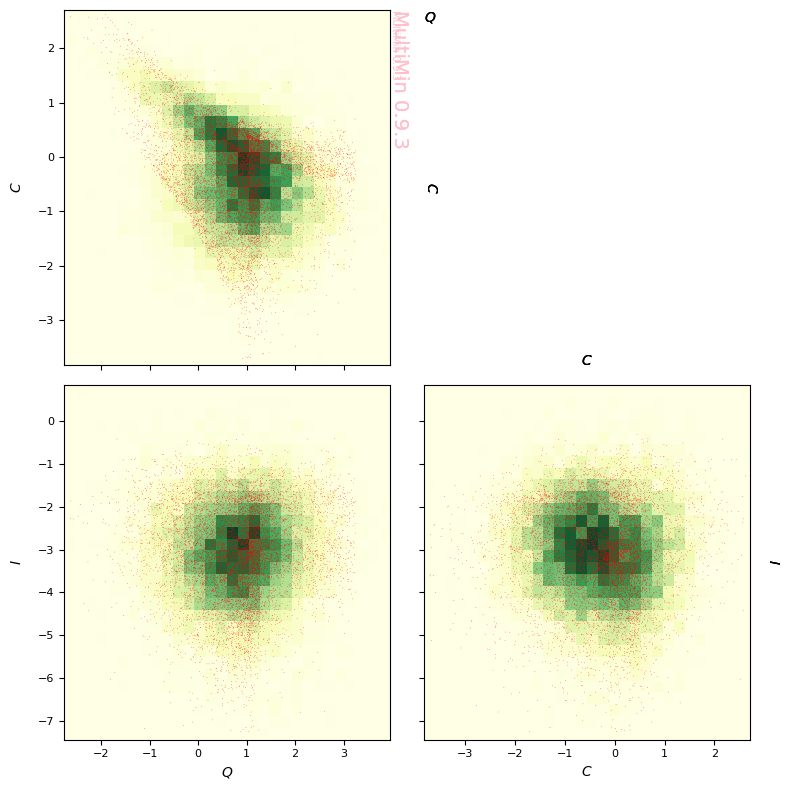

In [35]:
F=mn.FitCMND(ngauss=2,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=5,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.2, 2.2, 2.2, 2.9, 1.5, -2.2, 2.7, -0.025, -2.2, 1.9, 0.29, -2.9, 1.7, 0.33, -2.2, 0.33, 2.1, -2.1, -1.3, -1.2, -1.4, -1.4, -2.1, -2.4, -2.1, -3.1, -2, -2.3, -1.9, -2.1, -2.3, -1.2, -2, 2.4, 1.8, 1.3, 2.1, 1.3, 0.76, 0.16, 1.4, 0.86, 1.5, 1.4, 1.1, 0.61, 0.52, 1.1]
	LogL/N: 4.7431270585258565


Iter 10:
	Vars: [-1.6, 0.96, 0.4, -2.2, -0.2, 1.3, -0.29, -4, 0.96, -0.63, -3, 1, 0.3, -3.3, 2, -1.3, -2.8, -0.12, -0.36, -2.6, -2.4, -2.9, -1.7, -3.2, -2.7, -2.2, -2.4, -3.2, -2.3, -2.5, -2.2, -2, -2.6, -2, -2.3, -0.15, 1.2, -0.17, -0.5, 0.62, -0.27, -2.2, 0.39, -0.078, 1.2, 1.5, 0.68, -2.5, -0.041, 0.27]
	LogL/N: 3.7428225727960562


Iter 20:
	Vars: [-2.2, -0.41, -0.13, -1.7, -0.3, 1, -0.64, -4.5, 0.99, -0.48, -3.1, 1.2, 0.25, -3.3, 1.5, -0.84, -1.9, 0.038, -0.51, -2.9, -2.7, -2.6, -1.8, -3.5, -2.8, -2.3, -2.3, -3.2, -2.3, -2.4, -2.6, -3.2, -2.6, -2, -2.2, -0.64, 1, -0.74, -0.73, 0.41, -0.66, -2, 0.36, -0.03, -0.18, -0.12, 0.7, -2.4, -0.3, 0.43]
	LogL/N: 3.7229514743336347


Iter 23:
	Vars: [-2.2, -0.56, -0.25, -1.6, -0.38, 0.95, -0.64, -4.5, 1, -0.48, -3.2, 1.2, 0.24, -3.3, 1.4, -0.76, -1.9, 0.054, -0.52, -2.9, -2.8, -2.6, -1.9, -3.5, -2.8, -2.4, -2.3, -3.2, -2.4, -2.4, -2.5, -3.1, -2.6, -2, -2.3, -0.48, 0.77, -0.67, -0.77, 0.47, -0.81, -2, 0.41, -0.058, -0.45, -0.23, 0.73, -2.3, -0.29, 0.4]
	LogL/N: 3.7219281832410545
Elapsed time since last call: 12.3209 s
-log(L)/N = 3.7219281832410545
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.07028874182097956, 0.24638626618473755, 0.29679378337430795, 0.11160129476411725, 0.27492991385585763]
    Number of variables: 3
    Averages (μ): [[0.9519392151799442, -0.6390509687051257, -4.536684732919341], [1.0023478659127856, -0.48242965464143955, -3.152937067740178], [1.1782823548723214, 0.24232848093890472, -3.2912932237339962], [1.39965964202924, -0.7618856406099854, -1.872248282445463], [0.053824128684015045, -0.5237951798191919, -2.872670495857799]]
    Standard de

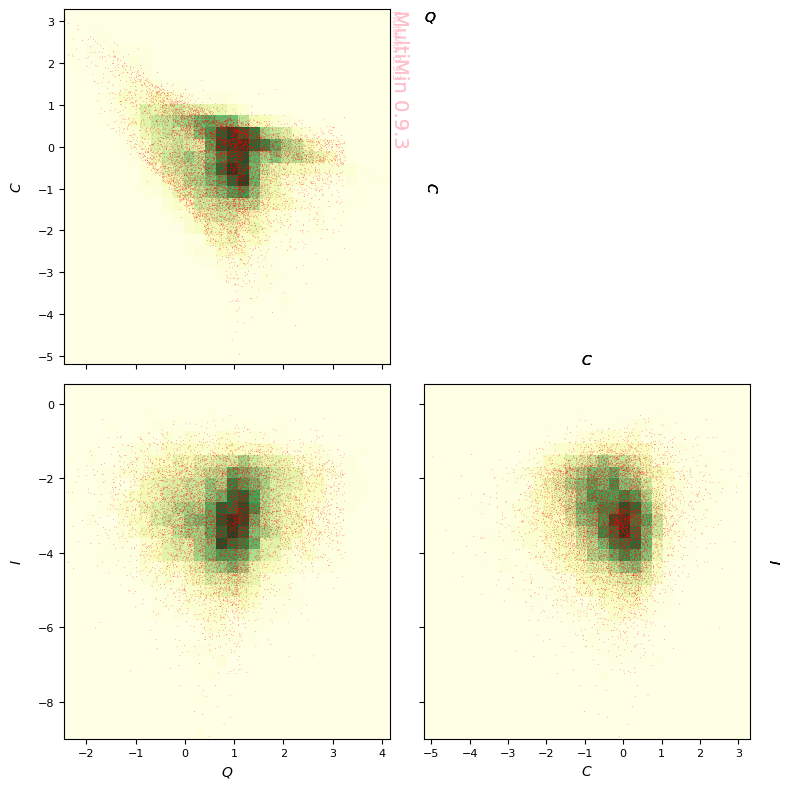

In [36]:
F=mn.FitCMND(ngauss=5,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=10,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            props=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted CMND and comparing to the data:

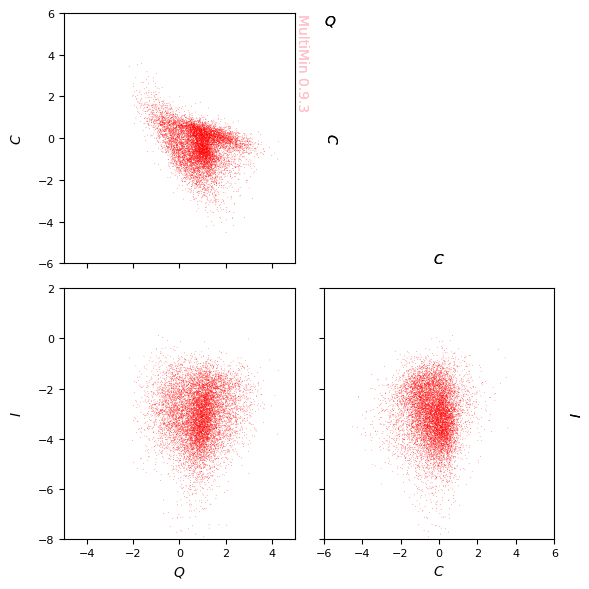

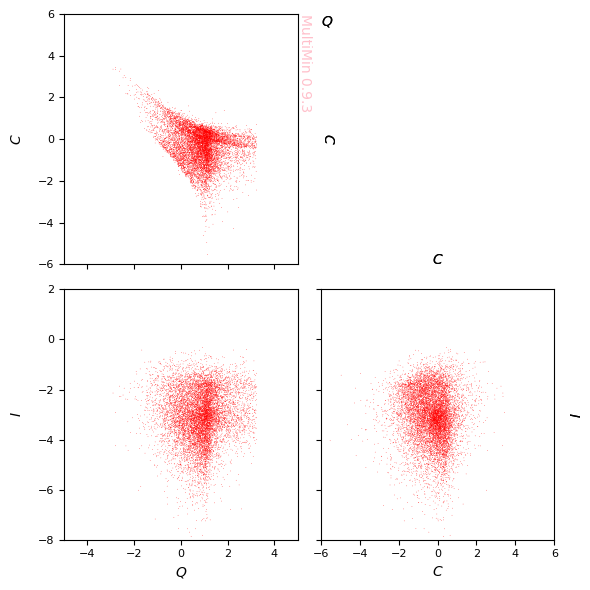

In [37]:
F.cmnd.plot_sample(N=len(F.data),
                  figsize=3,
                  props=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")
properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

In [38]:
function, cmnd = F.cmnd.get_function(properties=properties)

from multimin import nmd

def cmnd(X):

    mu1_Q = 0.951939
    mu1_C = -0.639051
    mu1_I = -4.536685
    mu1 = [mu1_Q, mu1_C, mu1_I]
    Sigma1 = [[0.32968, -0.094822, 0.276627], [-0.094822, 0.490158, -0.299296], [0.276627, -0.299296, 1.739673]]
    n1 = nmd(X, mu1, Sigma1)

    mu2_Q = 1.002348
    mu2_C = -0.48243
    mu2_I = -3.152937
    mu2 = [mu2_Q, mu2_C, mu2_I]
    Sigma2 = [[0.093299, -0.063312, 0.06119], [-0.063312, 0.316267, -0.187304], [0.06119, -0.187304, 0.75429]]
    n2 = nmd(X, mu2, Sigma2)

    mu3_Q = 1.178282
    mu3_C = 0.242328
    mu3_I = -3.291293
    mu3 = [mu3_Q, mu3_C, mu3_I]
    Sigma3 = [[0.789422, -0.257928, 0.154722], [-0.257928, 0.14776, -0.009729], [0.154722, -0.009729, 0.756177]]
    n3 = nmd(X, mu3, Sigma3)

    mu4_Q = 1.39966
    mu4_C = -0.761886
    mu4_I = -1.872248
    mu4 = [mu4_Q, mu4_C, mu4_I]
    Sigma4 = [[0.693853, -0.135073, -0.039774], [-0.135073, 0.545544, 0.109653], [-0.039774, 0.109653, 0.181645]]
    n4 = nmd(X, mu4, Sigma4)

    

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga